<a href="https://colab.research.google.com/github/saffarizadeh/INSY4054/blob/main/DeepFake_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://saffarizadeh.com/Logo.png" width="300px"/>

# *INSY 4054: Emerging Technologies*

# **Trained Models and Transfer Learning**
## **DeepFake - Advanced**

Instructor: Dr. Kambiz Saffarizadeh

---

# Improved Demo for paper "First Order Motion Model for Image Animation"

In [ ]:
!pip install ffmpeg-python

In [2]:
import matplotlib.pyplot as plt
import imageio
import cv2
from IPython.display import HTML
from skimage.transform import resize
import matplotlib.animation as animation
from google.colab import files
import requests
import numpy as np

In [ ]:
cd /content

# Loading a Photo

In [ ]:
#@title Choose an image { display-mode: "form" }

image_url = "https://www.saffarizadeh.com/ET/DF/statue-01.png" #@param @param ["https://www.saffarizadeh.com/ET/DF/statue-01.png", "https://www.saffarizadeh.com/ET/DF/statue-02.png", "https://www.saffarizadeh.com/ET/DF/statue-03.png", "https://www.saffarizadeh.com/ET/DF/statue-04.png"]
source_image = imageio.imread(image_url)

If you prefer to upload your own photo run the following code:

In [ ]:
uploaded_image = files.upload()
source_image = imageio.imread(list(uploaded_image.keys())[0])

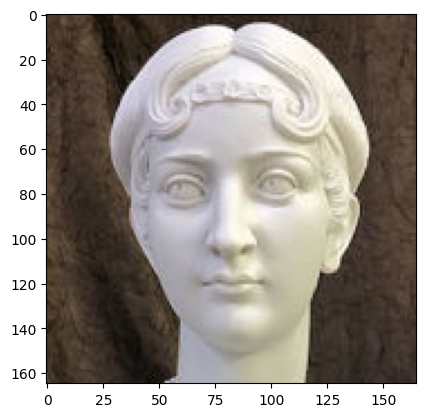

In [6]:
plt.imshow(source_image)

Download and resize the image.

In [7]:
source_image.shape # PNG pictures have 4 channels. The forth channel keeps a value for transparency

(165, 165, 4)

To properly crop the image around the face we first need to find the face. After finding the coordinates of the face, we can crop the image to become a square image centered around the face.

In [8]:
def crop_face_coordinates(image):
  # Detect the face in image
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = face_cascade.detectMultiScale(gray_image, 1.5, 1)
  # Get the coordinates of the face (the first face in the image)
  x, y, w, h = list(faces[0])
  return (y, y+h, x, x+w)

If the image is not already properly cropped, run the following code to use this function and crop the image.

In [9]:
# If the image is not already properly cropped, uncomment and run the following code to use this function and crop the image.
# (y1, y2, x1, x2) = crop_face_coordinates(source_image)
# source_image = source_image[y1:y2, x1:x2]

source_image = resize(source_image, (256, 256))[..., :3] # Here by using ":3" we are getting rid of the 4th channel of the image (if the image is a PNG)

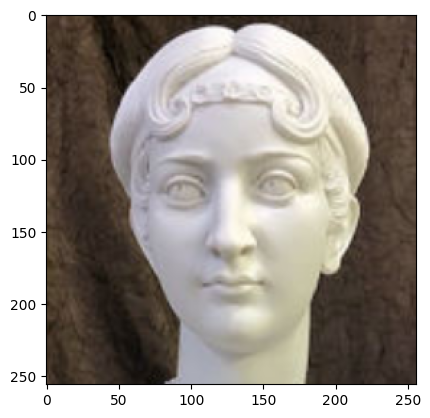

In [10]:
plt.imshow(source_image)

# Load Driving Video

In [ ]:
uploaded_video = files.upload()

In [12]:
video_file_name = list(uploaded_video.keys())[0]

We can use the `get_reader` method of `imageio` to load the video.

In [13]:
reader = imageio.get_reader(video_file_name)

We can also get the number of frames per second to be used later when we want to save the video.

In [14]:
fps = reader.get_meta_data()['fps']

We loop through the reader and create a list of frames.

In [15]:
driving_video = [frame for frame in reader]
reader.close()

We use the first frame of the video as the basis for face detection. We use the coordinates of the face from the first frame to crop the whole video. We also resize the video to 256 by 256.

In [16]:
# if we want to crop the whole video based on the first frame of the video:
(y1, y2, x1, x2) = crop_face_coordinates(driving_video[0])

cropped_video = []
for i, frame in enumerate(driving_video):
  # if we want to crop the video based on the position of face on each frame:
  #(y1, y2, x1, x2) = crop_face_coordinates(driving_video[i])
  cropped = frame[y1:y2, x1:x2]
  cropped_video.append(resize(cropped, (256, 256))[..., :3])

# Download the DeepFake Repository

In [ ]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

In [ ]:
cd first-order-model

# Create a Model and Load Checkpoints from the Downloaded Repository

In [ ]:
!gdown --id 1P27UddNfwV_NNbQqB40RkCPDaYnb9jwc # !wget https://saffarizadeh.com/ET/deep_animator_model.pth.tar

In [ ]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', checkpoint_path='deep_animator_model.pth.tar')

# Perform Image Animation

In [ ]:
cd /content

In [ ]:
from demo import make_animation
from skimage import img_as_ubyte

predictions = make_animation(source_image, cropped_video, generator, kp_detector, relative=True)

#save resulting video
imageio.mimsave('generated.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
#video can be downloaded from /content folder

To show the video here on the Notebook, we use the following function.

In [24]:
def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=fps, repeat_delay=1000)
    plt.close()
    return ani

In [25]:
HTML(display(source_image, cropped_video, predictions).to_html5_video())

# Add the Audio Back to the Animation

In [ ]:
cd /content

In [ ]:
!rm audio.mp3 && rm generated_with_audio.mp4

In [ ]:
import subprocess
_ = subprocess.call(f'ffmpeg -i {video_file_name} -f mp3 audio.mp3', shell=True)
_ = subprocess.call('ffmpeg -i generated.mp4 -i audio.mp3 -strict -2 -f mp4 generated_with_audio.mp4', shell=True)

In [ ]:
from base64 import b64encode
mp4 = open('generated_with_audio.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls><source src="%s" type="video/mp4"></video>""" % data_url)